# Tasks Test 

这个Jupyter Notebook主要记录个任务的完成情况以及个任务结果展示，以及需要文字回答和说明的部分。

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.linear_model import LinearRegression
import task1 as t1 
import task2 as t2 
import task3 as t3 

## 0.获取数据

In [2]:
# file path 
data_root_min = '/Users/huayuzhu/Desktop/exam/raw_data/minute'
data_root = '/Users/huayuzhu/Desktop/exam/raw_data/daily'
output_dir = '/Users/huayuzhu/Desktop/exam/'

# get minute level data 
amount = t2.get_min_data_from_csv(f'{data_root_min}/amount.csv')
volume = t2.get_min_data_from_csv(f'{data_root_min}/volume.csv')
close  = t2.get_min_data_from_csv(f'{data_root_min}/close.csv')
open  = t2.get_min_data_from_csv(f'{data_root_min}/open.csv')

#get daily data 
S_DQ_RET = t1.get_data_from_csv(f'{data_root}/S_DQ_RET.csv')
S_905_DQ_RET =  t1.get_data_from_csv(f'{data_root}/905S_DQ_RET.csv')
S_DQ_MV = t1.get_data_from_csv(f'{data_root}/S_DQ_MV.csv')
S_RESTRICT = t1.get_data_from_csv(f'{data_root}/S_RESTRICT.csv')
S_DQ_OPEN = t1.get_data_from_csv(f'{data_root}/S_DQ_OPEN.csv')
S_DQ_ADJ_FACTOR = t1.get_data_from_csv(f'{data_root}/S_DQ_ADJFACTOR.csv')
S_DQ_CLOSE =t1.get_data_from_csv(f'{data_root}/S_DQ_CLOSE.csv')
S_DQ_VOLUME = t1.get_data_from_csv(f'{data_root}/S_DQ_VOLUME.csv')
F7_26 =  t1.get_data_from_csv(f'{data_root}/F7_26.csv')
F7_27 =  t1.get_data_from_csv(f'{data_root}/F7_27.csv')

# construct new df accordingly 
S_DQ_ADJ_FACTOR = S_DQ_ADJ_FACTOR/100
S_ADJ_CLOSE = S_DQ_CLOSE * S_DQ_ADJ_FACTOR
S_ADJ_OPEN = S_DQ_OPEN * S_DQ_ADJ_FACTOR


## 1.单因子测试

### 1.1

这里展示了单因子测试给f27和f26。

- pipeline 假设： 
1. 无交易成本，周度换仓
2. 分别做多因子值 top 10% 和 bottom 10%
3. 周度投资金额由第一个时间点的价格决定
4. 选择均衡投资

- 可改进（有更多时间的话）的地方： 
1. 投资策略weight可以用其他更优化的方法
2. 可添加更多的benchmark比较，增加与fama french线性回归的分析

- 结果分析： 
1. f27 因子的表现总体比 f26因子差，如果考虑attribution and risk factor
2. 总体而言， top组合的表现不如bottom组合。


In [3]:
test1 = t1.TestInfo()
factor27 = t1.OneFactorTest(F7_27,S_DQ_OPEN)
factor27.plot_comparison_with_benchmark(test1,'F7_27')
display(factor27.compare_with_benchmark(test1,'F7_27',False).tail(1))
display(factor27.eval_combined(test1))

,Daily excess_return TOP,Cumulative excess_return TOP,Daily excess_return BOTTOM,Cumulative excess_return BOTTOM
2022-12-30,0.000714,-0.171656,-0.005739,0.418476


,,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Bottom,Peak
top,net_return,-0.033206,0.283651,-0.117065,-0.149175,-0.567716,2.480211,-0.068064,-0.103850,-0.189989,0.11883,-0.801874,2018-10-28,2015-06-21
bottom,net_return,0.046422,0.289178,0.160532,0.214823,-0.473867,1.898038,-0.067379,-0.099855,-0.182957,0.11355,-0.714176,2018-10-28,2015-06-21


In [4]:
factor26 = t1.OneFactorTest(F7_26,S_DQ_OPEN)
factor26.plot_comparison_with_benchmark(test1,'F7_26')
display(factor26.compare_with_benchmark(test1,'F7_26',False).tail(1))
display(factor26.eval_combined(test1))

,Daily excess_return TOP,Cumulative excess_return TOP,Daily excess_return BOTTOM,Cumulative excess_return BOTTOM
2022-12-30,0.000726,-0.122952,-0.007881,0.654683


,,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Bottom,Peak
top,net_return,-0.027117,0.276109,-0.098211,-0.127394,-0.471573,2.212817,-0.066418,-0.099623,-0.166284,0.129293,-0.779419,2018-10-28,2015-06-21
bottom,net_return,0.071689,0.289030,0.248032,0.352213,-0.241619,2.043080,-0.063268,-0.091796,-0.197650,0.139645,-0.666802,2018-10-28,2015-06-21


### 1.2 

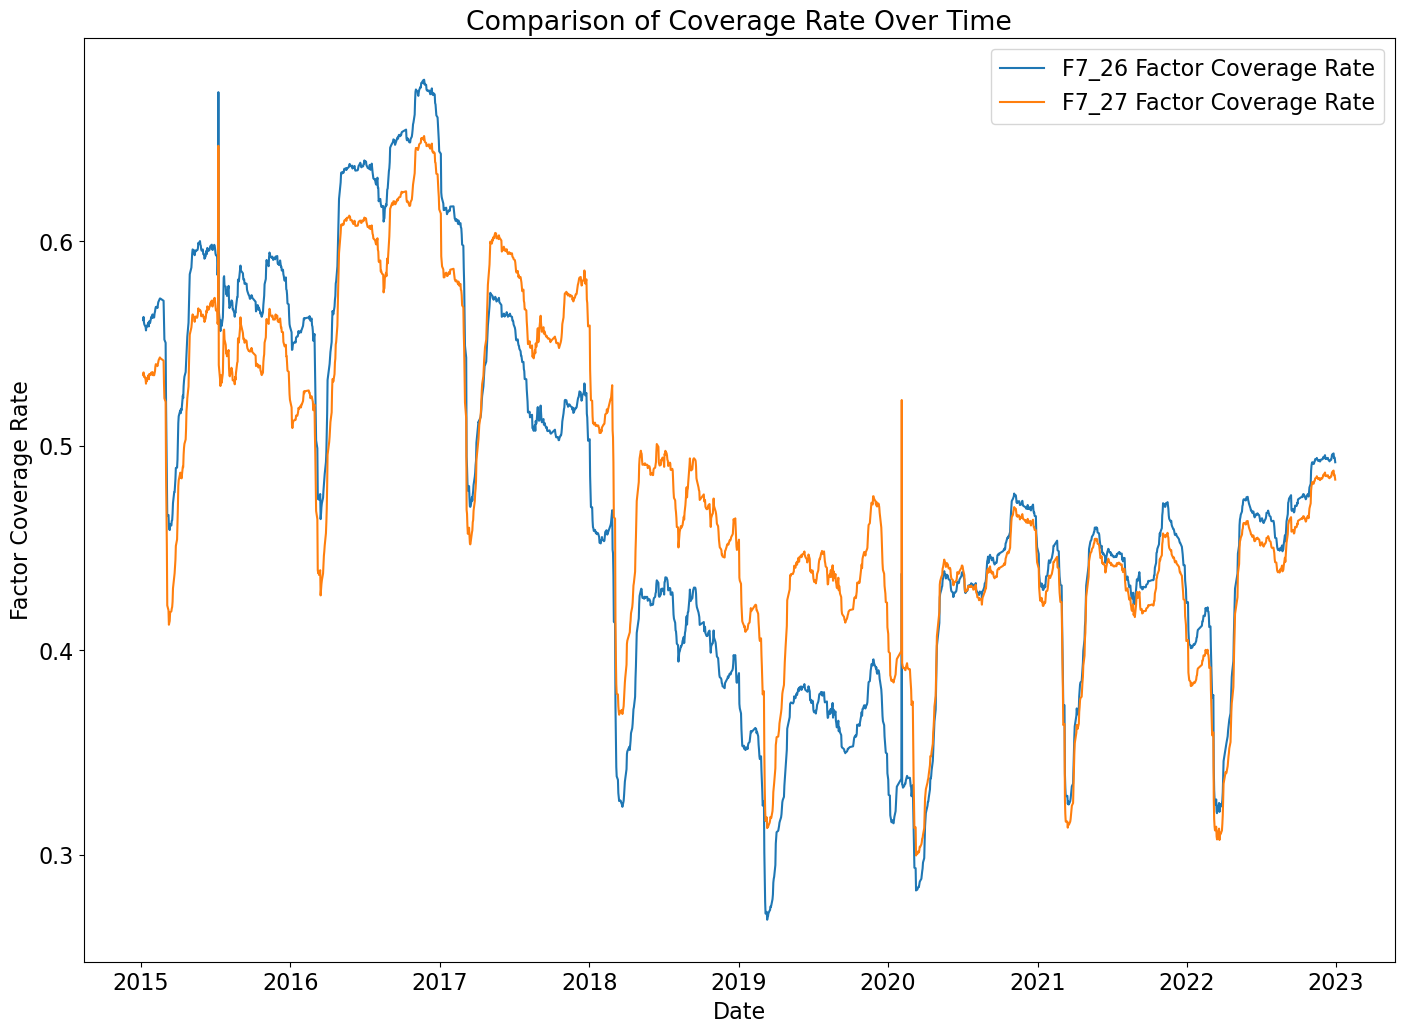

In [5]:
t1.factor_coverage_rate_plot(output = False)

### 1.3 

In [6]:
display(t1.neutralize_factors(F7_26,S_DQ_MV,'F7_26',output = False).head(5))
display(t1.neutralize_factors(F7_27,S_DQ_MV,'F7_27',output = False).head(5))

,1,2,3,4,5,6,7,8,9,10,...,873593,873665,873679,873690,873693,873703,873726,873749,873806,873833
2015-01-05,0.039026,0.835374,NaN,NaN,NaN,-0.303145,NaN,-4.329899,-0.591190,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,0.046715,0.720039,NaN,NaN,NaN,-0.361376,NaN,-4.331551,-0.591190,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,0.056327,0.720966,NaN,NaN,NaN,-0.358845,NaN,-4.337907,-0.593993,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,0.072987,0.720106,NaN,NaN,NaN,-0.379099,NaN,-4.346931,-0.594141,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09,0.069142,0.728291,NaN,NaN,NaN,-0.399353,NaN,-4.348584,-0.591412,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,1,2,3,4,5,6,7,8,9,10,...,873593,873665,873679,873690,873693,873703,873726,873749,873806,873833
2015-01-05,-0.186287,-0.200464,NaN,NaN,NaN,-0.070613,NaN,-3.696805,-0.489520,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,-0.179108,-0.680094,NaN,NaN,NaN,-0.128504,NaN,-3.698805,-0.489520,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,-0.170135,-0.632346,NaN,NaN,NaN,-0.125987,NaN,-3.706497,-0.483469,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,-0.154581,-0.607480,NaN,NaN,NaN,-0.146123,NaN,-3.717420,-0.483150,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09,-0.158171,-0.602023,NaN,NaN,NaN,-0.166259,NaN,-3.719421,-0.489042,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.因子实现(多因子模型)

### 2.1 

In [7]:
df_factor = t2.calculate_factor(S_ADJ_CLOSE, S_ADJ_OPEN,S_DQ_VOLUME , S_DQ_MV, N=20)[:-1]
factor_2016 = df_factor.loc['2016':]
display(factor_2016.head(5))

,1,2,3,4,5,6,7,8,9,10,...,873593,873665,873679,873690,873693,873703,873726,873749,873806,873833
2016-01-04,-0.001812,0.00002,NaN,-0.003,0.00882,0.001333,-0.004134,-0.001906,0.007051,0.001124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,-0.000651,-0.001463,NaN,-0.00412,0.00882,0.001333,-0.004162,-0.001813,0.007051,0.001124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,-0.001151,0.001934,NaN,-0.014035,0.007624,0.001333,-0.011306,-0.011447,-0.007915,-0.009565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,-0.001151,0.001934,NaN,-0.012878,0.007624,0.003531,-0.006111,-0.010513,-0.000709,-0.005678,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,-0.002867,-0.004873,NaN,-0.016989,-0.003304,0.001601,-0.000513,-0.011945,-0.003975,-0.008271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 假设： rankIC 计算是依据于月度数据。rankIC的计算使用的是spearman correlation。
- 改进的点：可以对ICIR进行数据分析，对factor的预测能力进行分析。

In [8]:
t2.calc_ICIR(df_factor.loc['2016':],S_DQ_OPEN.loc['2016':],5).head(5)

,1,2,3,4,5,6,7,8,9,10,...,873593,873665,873679,873690,873693,873703,873726,873749,873806,873833
0,-0.30506,-0.054287,NaN,-0.222357,-0.052657,-0.06102,-0.154547,-0.061415,-0.154769,-0.165908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
factor1 = t1.OneFactorTest(df_factor,S_DQ_OPEN)
display(factor1.compare_with_benchmark(test1,'Factor1',False).tail(1))
display(factor1.eval_combined(test1))

,Daily excess_return TOP,Cumulative excess_return TOP,Daily excess_return BOTTOM,Cumulative excess_return BOTTOM
2022-12-29,-0.012321,-1.546465,-0.007427,2.793988


,,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Bottom,Peak
top,net_return,-0.199148,0.295607,-0.673690,-0.884732,-0.488989,1.392574,-0.077455,-0.109400,-0.175452,0.115118,-0.935626,2023-01-01,2015-06-21
bottom,net_return,0.338010,0.302084,1.118928,1.922838,0.327903,1.472867,-0.061041,-0.080312,-0.149693,0.185501,-0.398963,2022-10-16,2021-09-05


根据之前的因子，改进的新因子。只改变了最大20%和最小20%的配比，改变了我们对于这两个部分重要的看法。更改后的因子调整包括减少高换手率日的影响，增加低换手率日的影响。这种调整可视为与逆向投资策略相一致。逆向投资者通常在别人卖出股票时买入（低换手率可能表明卖出疲劳或缺乏兴趣），在别人买入时卖出（高换手率可能表明兴趣达到顶峰）。市场往往对好消息反应过度，买盘过多，导致高换手率。通过将这些时期的收益减半，该因子可减少对可能不可持续的看涨趋势的重视。

- 结果分析： 
可以通过evaluation metrics, 可以得知更改后的因子并没有提高sharpe ratio 也无较少风险值。应该尝试其他的调整方向。

In [10]:
df_factor_2 = t2.calculate_adjusted_turnover_weighted_returns(S_ADJ_CLOSE, S_ADJ_OPEN,S_DQ_VOLUME , S_DQ_MV, N=20)[:-1]
factor_2_2016 = df_factor.loc['2016':]
display(df_factor_2.head(5))

,1,2,3,4,5,6,7,8,9,10,...,873593,873665,873679,873690,873693,873703,873726,873749,873806,873833
2015-02-02,-0.025343,-0.027047,NaN,-0.007189,NaN,-0.012369,-0.003687,0.008211,-0.000088,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-03,-0.034706,-0.025239,NaN,-0.013319,NaN,-0.012307,-0.003687,0.008211,-0.000324,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-04,-0.019608,-0.025239,NaN,-0.013375,NaN,-0.011177,-0.003551,0.01325,0.005916,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-05,-0.018893,-0.025239,NaN,-0.006471,NaN,-0.009617,-0.003551,0.01325,-0.00164,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-06,-0.013197,-0.0204,NaN,-0.007415,NaN,-0.009617,-0.003622,0.01325,-0.00164,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
factor1_2 = t1.OneFactorTest(df_factor_2,S_DQ_OPEN)
display(factor1_2.compare_with_benchmark(test1,'Factor1.2',False).tail(1))
display(factor1_2.eval_combined(test1))

,Daily excess_return TOP,Cumulative excess_return TOP,Daily excess_return BOTTOM,Cumulative excess_return BOTTOM
2022-12-29,-0.011701,-0.815827,-0.01017,2.260715


,,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Bottom,Peak
top,net_return,-0.107120,0.335536,-0.319252,-0.425178,-0.354416,2.035168,-0.082510,-0.118265,-0.188442,0.167647,-0.884450,2023-01-01,2015-06-21
bottom,net_return,0.271046,0.307957,0.880142,1.324567,-0.065175,1.544948,-0.067182,-0.092949,-0.184050,0.169033,-0.444243,2015-09-27,2021-12-05


### 2.2

公式使用的是：$vwap_d = \frac{\sum_d amount}{\sum_d volume}$

In [12]:
vwap_1 = t2.calc_VWAP(amount,volume, 1)
vwap_5 = t2.calc_VWAP(amount,volume, 5)
vwap_10 = t2.calc_VWAP(amount,volume, 10)
display(vwap_1.head(5))
display(vwap_5.head(5))
display(vwap_10.head(5))

,000001,000002,000009,000027,000063,000066,000069,000100,000157,000166,...,688122,688126,688180,688188,688363,688390,688561,688599,688777,688981
minute_idx,,,,,,,,,,,,,,,,,,,,,
2021-01-05,17.946726,27.505112,7.735928,6.001334,34.475078,20.339465,6.769819,7.275951,10.619454,5.208691,...,79.292819,33.867132,79.827627,285.239011,150.339939,262.877382,139.350105,23.263294,105.133945,58.084618
2021-01-06,19.029367,28.507546,7.463576,5.929580,33.653214,20.126884,6.815642,7.269706,10.710026,5.196806,...,78.550219,34.016575,84.082767,283.722473,149.688347,282.496264,136.264224,22.496276,100.773869,60.079660
2021-01-07,19.580970,28.570334,7.692533,5.997914,32.534517,19.465705,6.697741,7.320047,11.311926,5.163866,...,75.465708,32.681227,81.367047,277.064002,140.460357,316.991392,133.181666,23.801413,96.840484,58.816626
2021-01-08,19.488472,29.209726,7.302347,5.999201,34.077432,19.629873,6.710894,7.388083,11.455648,5.239748,...,69.034705,32.756370,79.738713,281.931204,136.846211,294.294866,130.422940,23.695520,97.710035,60.925255
2021-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,000001,000002,000009,000027,000063,000066,000069,000100,000157,000166,...,688122,688126,688180,688188,688363,688390,688561,688599,688777,688981
minute_idx,,,,,,,,,,,,,,,,,,,,,
2021-01-09,18.939591,28.385723,7.589975,5.987972,33.611402,19.833047,6.743522,7.303339,11.045830,5.199844,...,74.405998,33.283770,81.783454,280.872325,142.435710,295.321923,134.837730,23.257829,99.097479,59.386752
2021-01-10,19.311642,28.714119,7.551617,5.982599,33.223150,19.659916,6.735900,7.321640,11.223589,5.197443,...,73.154256,33.094979,82.137602,279.693117,141.089188,301.922829,133.455404,23.256559,97.847699,59.793517
2021-01-11,19.895453,29.521570,7.421459,5.959496,33.879179,19.897213,6.701374,7.578395,11.477848,5.186582,...,71.619186,32.609882,80.602636,282.923933,144.830424,296.432435,130.024245,23.233243,97.049934,61.172780
2021-01-12,20.179842,29.766804,7.164903,5.893499,34.696342,20.130787,6.680994,8.132412,11.674031,5.177259,...,70.839575,32.221421,79.477413,285.673354,151.525729,285.724620,119.517226,22.662650,97.588702,62.873257
2021-01-13,20.467211,29.900653,7.143909,5.997093,35.747574,19.929051,6.687938,8.487852,12.022416,5.163795,...,71.593804,32.163146,78.459718,282.832128,159.555394,280.951336,115.852671,21.820123,98.945473,63.268088


,000001,000002,000009,000027,000063,000066,000069,000100,000157,000166,...,688122,688126,688180,688188,688363,688390,688561,688599,688777,688981
minute_idx,,,,,,,,,,,,,,,,,,,,,
2021-01-14,19.569395,29.241248,7.376640,6.003425,35.016802,19.814759,6.729800,8.209815,11.538914,5.175529,...,73.131016,35.010232,80.696246,281.307026,152.066388,286.631035,123.966069,22.549729,100.010719,62.305841
2021-01-15,20.088145,29.547853,7.311838,6.000807,35.074403,19.524602,6.737306,8.442808,11.668865,5.166355,...,71.041521,35.067391,80.335418,278.912165,152.303367,287.162441,121.680873,22.406032,99.267382,62.619777
2021-01-16,20.333270,29.697672,7.294355,6.008147,35.159697,19.470015,6.726089,8.512823,11.740444,5.163455,...,70.481856,35.132958,79.720166,278.354020,152.443764,287.511086,119.623676,22.383842,99.111524,62.842405
2021-01-17,20.480135,29.861673,7.151358,6.012052,35.594403,19.471115,6.732338,8.619976,11.842165,5.163392,...,69.472963,35.398297,79.202734,278.802344,156.145098,281.547103,117.968145,21.971170,100.045197,63.407114
2021-01-18,21.091885,30.149589,7.171243,6.000361,35.874864,19.412880,6.778896,8.922888,11.879256,5.150821,...,69.487550,35.824433,79.278658,277.858604,157.994174,278.889314,116.219573,21.614197,100.014676,63.440003


### 2.3

In [13]:
day_corr,morning_corr = t2.calc_large_order_corr(volume,open,close)
display(day_corr.head(5))
display(morning_corr.head(5))

,000001,000002,000009,000027,000063,000066,000069,000100,000157,000166,...,688122,688126,688180,688188,688363,688390,688561,688599,688777,688981
2021-01-04,-0.327224,-0.555101,0.531900,0.301387,0.351667,0.344849,-0.333210,0.168635,0.243753,-0.012840,...,0.322522,0.202412,-0.014754,0.326352,0.485528,0.039258,0.563508,0.422482,0.325976,0.215671
2021-01-05,-0.311909,-0.624122,-0.166841,-0.616699,0.393797,0.103684,-0.096274,0.460883,0.501025,-0.138274,...,0.076585,0.333775,-0.054076,-0.104857,0.062112,-0.142718,0.205283,-0.347443,0.292342,0.195254
2021-01-06,0.397444,0.513055,-0.400054,0.456413,-0.524403,-0.288022,0.180786,-0.412032,-0.100799,-0.071341,...,-0.048721,0.159435,0.412283,-0.146718,-0.398985,0.192866,-0.067573,-0.204029,-0.419826,0.478954
2021-01-07,0.129480,0.208718,0.270795,-0.034009,-0.291070,-0.245637,-0.120809,0.288800,0.459694,0.003380,...,-0.303452,-0.351338,-0.458833,0.079021,-0.018774,0.272091,-0.296527,0.385706,-0.179985,0.110758
2021-01-08,-0.389859,0.276109,-0.337289,0.098120,0.530902,0.380847,-0.069470,0.283693,-0.353185,0.148409,...,-0.159348,0.207230,0.253299,0.553652,-0.483761,-0.222592,0.294056,-0.273532,0.133139,0.351733


,000001,000002,000009,000027,000063,000066,000069,000100,000157,000166,...,688122,688126,688180,688188,688363,688390,688561,688599,688777,688981
2021-01-04,-0.379202,-0.598692,0.574670,0.196515,-0.590203,0.418385,-0.227693,0.144734,0.191250,-0.287319,...,0.412252,0.298939,-0.046390,0.389353,0.468628,-0.034385,0.530033,0.416965,-0.056247,0.247992
2021-01-05,-0.378985,-0.673460,-0.313473,-0.648667,0.396867,0.241189,-0.145144,0.473572,0.631487,-0.375585,...,0.124234,0.436126,0.104300,-0.157722,-0.039864,-0.084531,0.019551,-0.169499,0.400659,0.331183
2021-01-06,0.394191,0.557308,-0.457070,0.032386,-0.475601,-0.202274,0.482256,-0.510133,-0.331664,-0.012629,...,-0.060963,0.356351,0.496784,-0.096960,-0.434035,0.295598,0.083000,-0.242750,-0.586482,0.474151
2021-01-07,0.226625,0.490035,0.311505,0.107141,-0.316286,-0.283986,-0.270829,0.300045,0.593152,-0.022950,...,-0.249184,-0.427048,-0.361797,0.356574,0.113673,0.406520,-0.470183,0.368268,-0.483961,0.381093
2021-01-08,-0.522274,0.215632,-0.269574,0.042000,0.523554,0.487444,-0.021505,0.395952,-0.472546,0.294256,...,-0.062172,0.087518,0.256944,0.339232,-0.491221,-0.240393,0.297438,-0.314221,0.462531,0.562664


## 3.研报实现

### 3.1 
该因子可能旨在捕捉交易成本或交易对价格的影响，流动性较差的股票往往受此影响较大。分子捕捉价格影响，因为当回报波动较大时，价格影响往往较大。分母的目的可能是通过交易活动量将这种影响正常化，假设交易量越大，流动性越高。

这一系数背后的经济逻辑可能基于这样一个前提，即交易成本较高、交易对价格影响较大的证券（流动性较差的证券）会提供溢价，以补偿投资者交易这些证券的较高成本和风险。


### 3.2

In [15]:
illi = t3.illiquidty_factor(t2.open,t2.close,t2.amount,5)

open_price = open.resample('D').mean() 
illi_factor = illi.resample('D').mean() 

test1 = t1.TestInfo()
factor3 = t1.OneFactorTest(illi_factor,open_price)

display(factor3.compare_with_benchmark(test1,'factor3',False).tail(1))

display(factor3.eval_combined(test1))

,Daily excess_return TOP,Cumulative excess_return TOP,Daily excess_return BOTTOM,Cumulative excess_return BOTTOM
2022-12-30,0.001832,-0.194592,-0.01018,0.640609


,,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Bottom,Peak
top,net_return,-0.109970,0.258153,-0.425987,-0.752392,0.206917,-0.401586,-0.058567,-0.068403,-0.091531,0.089157,-0.432596,2022-11-06,2021-02-21
bottom,net_return,0.215823,0.248094,0.869925,1.460926,0.444578,1.875208,-0.048614,-0.065937,-0.090446,0.130187,-0.254659,2022-05-01,2022-12-04


### 3.3 
这个主题因子利用对数变换累计产品的方式，来捕捉资产的流动性状况，其特点是通过累乘的方式来强调流动性随时间变化的非线性影响，并通过整个交易周期的总成交额来归一化。利用总成交额归一化后可以剔除其他多余影响，更专注于流动性捕捉，因此会比另一个因子提高信息量。

### 3.4 
1. 基于成交量加权的流动性因子：

变种：通过赋予高成交量分钟更大的权重，将成交量权重纳入流动性计算，这可能对价格变动有更大的影响。

公式：用成交量加权的金额替换分母中的 Amount_t，这可以是成交量和价格的乘积（Volume_t * Price_t）。

2. 时间衰减的流动性因子：

变种：对绝对回报应用时间衰减，赋予最近回报更大的权重，以捕捉最新的市场状况。
公式：修改分子中的累计乘积，以应用衰减因子，使得最近的回报有更大的影响：$\Pi_t(1+w_t*|Return_t|)$，其中 w_t 是随时间减少的权重。

3. 考虑市场状况调整的流动性因子：


变种：通过整体市场的成交量或波动率来调整流动性因子，以区分市场宽泛的流动性和特定股票的流动性。

公式：用市场宽泛的流动性度量来除以 illiquidty factor，例如市场指数的平均成交量或波动性。

这里我们选择的时间衰减的流动性因子，从evaluation metric对比可以看出来，并没有显著的差别。可能因为decay ratio的选择。 

In [16]:
time_decayed_illiquidity = t3.calculate_time_decayed_illiquidity(t2.close, t2.open, t2.amount,t=5)


In [17]:
deccay_illi_factor = time_decayed_illiquidity.resample('D').mean() 
factor4 = t1.OneFactorTest(deccay_illi_factor,open_price)
display(factor4.compare_with_benchmark(test1,'factor4',False).tail(1))
display(factor4.eval_combined(test1))

,Daily excess_return TOP,Cumulative excess_return TOP,Daily excess_return BOTTOM,Cumulative excess_return BOTTOM
2022-12-30,0.001832,-0.195459,-0.01018,0.636957


,,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Bottom,Peak
top,net_return,-0.110229,0.258134,-0.427024,-0.754873,0.207965,-0.401329,-0.058567,-0.068403,-0.091531,0.089157,-0.433050,2022-11-06,2021-02-21
bottom,net_return,0.214299,0.247667,0.865270,1.448266,0.445041,1.903720,-0.048614,-0.065937,-0.090446,0.130187,-0.253255,2022-05-01,2022-12-04
